In [1]:
import pdal
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import scipy.spatial
import pyproj
import open3d as o3d

import os
import requests
import json
import sys
import urllib.request


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
LC_laz = '/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/points.laz'

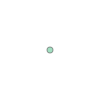

In [3]:
point = shapely.geometry.Point([-106.575331, 32.35488])
point

In [4]:
os.chdir('/home/jose/Desktop/LiDAR_nmsu/SouthEastB1')
os.listdir()

['TEST.ply',
 'isosurface_tri.ply',
 'shape.geojson',
 'point.geojson',
 'shape.qmd',
 'points.laz',
 'points.las',
 'for_open3d.las',
 'isosurf.json',
 'output.tin.tar.gz']

In [9]:
decompress = {
    "pipeline": [ LC_laz,
        
      
                 
        {
            "type": "writers.las",
            "filename":"./points.las",
            
        },
        
        
    ]}
pipeline = pdal.Pipeline(json.dumps(decompress))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points))

CPU times: user 1min 7s, sys: 3.1 s, total: 1min 10s
Wall time: 1min 9s
Pipeline selected 95161968 points (95161968.0 pts/m2)


In [5]:
LC_las = '/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/points.las'

In [6]:
cropper = {
    "pipeline": [ LC_las,
        
        # Cropping out all points that lie 200 units from point.wkt
        {   "type":"filters.crop",
             "a_srs": "EPSG:4326",
             "point":point.wkt,
             "distance": 400
        },
          
                 
        {   "type":"filters.eigenvalues",
            "knn":16},
                 # computing normal X,Y,Z components of planes generated by 16 nn. (Also calculates curvature)
        {   "type":"filters.normal",
            "knn":16},
                 
        {
            "type": "writers.las",
            "filename":"for_open3d.las",
            
        },
        
        
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points))

CPU times: user 34.1 s, sys: 3.12 s, total: 37.2 s
Wall time: 37.5 s
Pipeline selected 1164109 points (1164109.0 pts/m2)


In [7]:
#creating numpy and pandas objects from pdal pipeline
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [8]:
df#['']


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,Eigenvalue0,Eigenvalue1,Eigenvalue2,NormalX,NormalY,NormalZ,Curvature,X_0,Y_0,Z_0
0,563.62,581.92,340.71,1936,2,2,0,0,2,9.0,...,0.002252,0.532097,1.074479,-0.001344,0.546858,0.837224,0.001400,351968.82,3581045.21,2408.76
1,566.90,583.63,340.77,4096,1,1,0,0,2,9.0,...,0.055045,1.478559,1.910590,-0.375071,0.625247,0.684389,0.015982,351972.10,3581046.92,2408.82
2,567.17,584.61,340.31,5360,1,1,1,0,2,9.0,...,0.060930,1.111812,1.442719,-0.468953,0.421808,0.775990,0.023296,351972.37,3581047.90,2408.36
3,565.31,584.42,339.26,4336,1,1,1,0,2,9.0,...,0.028117,0.748708,1.390782,-0.306486,0.541558,0.782803,0.012971,351970.51,3581047.71,2407.31
4,563.60,584.22,339.25,1856,2,2,1,0,2,9.0,...,0.005491,0.615122,1.363350,-0.078484,0.587302,0.805554,0.002768,351968.80,3581047.51,2407.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164104,46.39,632.93,88.05,6400,1,1,0,0,2,-2.0,...,0.003061,0.957446,1.158273,-0.369015,-0.302937,0.878668,0.001445,351451.59,3581096.22,2156.10
1164105,41.62,632.41,85.75,4720,1,1,1,0,2,-1.0,...,0.009049,0.510981,0.719597,-0.330952,-0.135415,0.933881,0.007299,351446.82,3581095.70,2153.80
1164106,40.13,632.07,85.30,6000,1,1,1,0,2,-1.0,...,0.003266,0.592381,0.932353,-0.317255,-0.053188,0.946847,0.002138,351445.33,3581095.36,2153.35
1164107,40.34,632.80,85.39,6352,1,1,0,0,2,-1.0,...,0.001956,0.231349,1.206789,-0.258800,-0.082042,0.962441,0.001358,351445.54,3581096.09,2153.44


In [ ]:
# Generating a PCD from XYZ .las data 

In [54]:
# Not necessary to make PCD but nice to have the code to do so
array = np.asarray(df[["X","Y","Z"]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(array)
o3d.io.write_point_cloud("./TEST.ply", pcd)

True

In [56]:
pcd_load = o3d.io.read_point_cloud("/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/TEST.ply")
o3d.visualization.draw_geometries([pcd_load])

In [14]:
# Loading in mesh

In [15]:
mesh = o3d.io.read_triangle_mesh("/home/jose/Desktop/LiDAR_nmsu/SouthEastB1/isosurface_tri.ply",print_progress=True)
o3d.visualization.draw_geometries([mesh])

In [16]:
print('These are the vertices!!!')
print(np.asarray(mesh.vertices))
print()
print('These are the triangle faces!!!')
print(np.asarray(mesh.triangles))



These are the vertices!!!
[[3.51969e+05 3.58105e+06 2.40876e+03]
 [3.51972e+05 3.58105e+06 2.40882e+03]
 [3.51972e+05 3.58105e+06 2.40836e+03]
 ...
 [3.51445e+05 3.58110e+06 2.15335e+03]
 [3.51446e+05 3.58110e+06 2.15344e+03]
 [3.51446e+05 3.58110e+06 2.15351e+03]]

These are the triangle faces!!!
[[ 539739  539690  539691]
 [ 539739  539689  539690]
 [ 539739  545991  539689]
 ...
 [1050201 1050346 1050044]
 [1050044 1050346 1049757]
 [1049757 1050346 1049310]]


*** NOTE: PDAL allows you to compute normals during pipeline for .las... ###

However...

Not for the commandline pipeline of a isosurface.ply file...
So... untill you can find a way to stream line python + comandline in PDAL. This is the only way to compute normals
of a mesh. intother words... untill you get scipy.spatial.Delaunay() to play well with open3d...

In [17]:
print("Does mesh have normals? (exist: " + str(mesh.has_vertex_normals())+').... :(')


Does mesh have normals? (exist: False).... :(


In [18]:
mesh.compute_vertex_normals() # computing normals

TriangleMesh with 1164109 points and 2327726 triangles.

In [19]:
print("How about now? (normals exist: " + str(mesh.has_vertex_normals())+').... :)')

How about now? (normals exist: True).... :)


In [20]:
o3d.visualization.draw_geometries([mesh])

In [21]:
# PAINTING STUFF!!!
print("Painting the mesh")
mesh.paint_uniform_color([0.55, .15, 0.2])
o3d.visualization.draw_geometries([mesh])


Painting the mesh


In [ ]:
# Average Mesh Filtering

In [22]:
# making a copy of original mesh to mess around with it
import copy
mesh1 = copy.deepcopy(mesh)

In [23]:
print('filter with average with 1 iteration')
mesh_out = mesh1.filter_smooth_simple(number_of_iterations=5)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

filter with average with 1 iteration


In [63]:
print('filter with average with 5 iterations')
mesh_out = mesh1.filter_smooth_simple(number_of_iterations=5)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])



filter with average with 5 iterations


In [24]:
o3d.visualization.draw_geometries([mesh_out],mesh_show_wireframe=True)

In [56]:
mesh_smp = mesh1.simplify_quadric_decimation(target_number_of_triangles=2100000)

In [57]:
o3d.visualization.draw_geometries([mesh_smp],mesh_show_wireframe=True)

In [58]:
print('filter with average with 1 iterations')
mesh_out = mesh_smp.filter_smooth_simple(number_of_iterations=5)
mesh_smp.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

filter with average with 1 iterations


In [60]:
o3d.visualization.draw_geometries([mesh_out],mesh_show_wireframe=True)

# Trying scipy delaunay

In [45]:
df['ground'] = df['Classification']==2

ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='blue')

In [43]:
ma = o3d.utility.Vector3dVector(ground_delaunay.simplices)

In [32]:
ma.compute_vertex_normals()

AttributeError: 'open3d.cpu.pybind.utility.Vector3dVector' object has no attribute 'compute_vertex_normals'

In [57]:
pcd_load.estimate_normals()

In [58]:
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [60]:
np.asarray(pcd_load.normals)

array([[ 0.14765081, -0.70279083, -0.69590537],
       [-0.44238516,  0.56666631,  0.69511485],
       [-0.56208614,  0.37093801,  0.73923215],
       ...,
       [ 0.33482894,  0.06926929, -0.9397294 ],
       [-0.33322049, -0.09464182,  0.9380869 ],
       [ 0.35321759,  0.10795704, -0.92929146]])

In [62]:
pcd_load.orient_normals_consistent_tangent_plane(100)  # change this to 16 when you finish and compare!

In [63]:
np.asarray(pcd_load.normals)

array([[-0.14765081,  0.70279083,  0.69590537],
       [-0.44238516,  0.56666631,  0.69511485],
       [-0.56208614,  0.37093801,  0.73923215],
       ...,
       [-0.33482894, -0.06926929,  0.9397294 ],
       [-0.33322049, -0.09464182,  0.9380869 ],
       [-0.35321759, -0.10795704,  0.92929146]])

In [64]:
df[['NormalX','NormalY','NormalZ']]

,NormalX,NormalY,NormalZ
0,-0.001344,0.546858,0.837224
1,-0.375071,0.625247,0.684389
2,-0.468953,0.421808,0.775990
3,-0.306486,0.541558,0.782803
4,-0.078484,0.587302,0.805554
...,...,...,...
1164104,-0.369015,-0.302937,0.878668
1164105,-0.330952,-0.135415,0.933881
1164106,-0.317255,-0.053188,0.946847
1164107,-0.258800,-0.082042,0.962441


In [ ]:
radii = [0.5, 0.1, 0.2, 0.4]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd_load, o3d.utility.DoubleVector(radii))

In [68]:
o3d.visualization.draw_geometries([pcd_load])